### Imports

In [1]:
# For Docker image tensorflow/tensorflow:2.14.0-gpu-juptyer and latest-gpu-jupyter 
# About the latest tag: sha256:efc25f8ad0ec337e8f4e2de9e7e8e391e6729481c7a7cae4bdea3137da7822c6
!pip install -q nltk
!pip install -q transformers
!pip install -q tf-keras

In [2]:
from typing import Union
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
from numpy import ndarray
import tensorflow as tf

2024-04-21 20:36:23.118492: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# The device_name will be used in model.fit()
gpu_devices = tf.config.experimental.list_physical_devices("GPU")

if gpu_devices:
    print("GPU available, using GPU")
    tf.config.experimental.set_visible_devices(gpu_devices[0], "GPU")
    device_name = "/GPU:0"
else:
    print("GPU not available, using CPU")
    device_name = "/CPU:0"

GPU available, using GPU


2024-04-21 20:36:24.311015: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 20:36:24.315828: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 20:36:24.315862: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### Function for loading data set

In [4]:
def load_text_file(file_path: str) -> list[str]:
    """
    Load a text file and return an array of lines from the file.

    Args:
        file_path: str: The path to the file to load.

    Returns:
        list[str]: An array of lines from the file.
    """
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

### Load the text files

In [5]:
train_text_path: str = "../dataset/train_text.txt"
train_label_path: str = "../dataset/train_labels.txt"

test_text_path: str = "../dataset/test_text.txt"
test_label_path: str = "../dataset/test_labels.txt"

validationt_text_path: str = "../dataset/val_text.txt"
validationt_label_path: str = "../dataset/val_labels.txt"

train_text: list[str] = load_text_file(train_text_path)
train_label: list[str] = load_text_file(train_label_path)

test_text: list[str] = load_text_file(test_text_path)
test_label: list[str] = load_text_file(test_label_path)

validation_text: list[str] = load_text_file(validationt_text_path)
validation_label: list[str] = load_text_file(validationt_label_path)

### Preprocessing

#### Download the NLTK resources and declere global variables

In [6]:
# Set stopwords
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)
nltk.download("vader_lexicon", quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
stopwords = set(nltk.corpus.stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Declare a dict of emojis and their corresponding sentiment
# 0: Negative; 1: Neutral; 2: Positive
emoji_dict = {
    "😊": 2,
    "😂": 2,
    "😭": 0,
    "😍": 2,
    "😘": 2,
    "😁": 2,
    "😩": 0,
    "😏": 2,
    "😉": 2,
    "😎": 2,
    "😢": 0,
    "😅": 2,
    "😱": 0,
    "😆": 2,
    "😋": 2,
    "😷": 0,
    "😔": 0,
    "😒": 0,
    "😡": 0,
    "😪": 0,
    "😤": 0,
    "😝": 2,
    "😓": 0,
    "😖": 0,
    "😣": 0,
    "😞": 0,
    "😐": 1,
    "😕": 0,
    "😫": 0,
    "😨": 0,
    "😌": 2,
    "😜": 2,
    "😑": 1,
    "😬": 0,
    "😈": 0,
    "😯": 0,
    "😳": 0,
    "😇": 2,
    "😷": 0,
    "😴": 0,
    "😲": 0,
    "😵": 0,
    "😦": 0,
    "😢": 0,
    "😮": 0,
    "😟": 0,
    "😥": 0,
    "😧": 0,
    "😰": 0,
    "😓": 0,
    "😩": 0,
    "😿": 0,
    "😾": 0,
    "🙀": 0,
    "🙅": 0,
    "🙆": 0,
    "🙇": 0,
    "🙈": 0,
    "🙉": 0,
    "🙊": 0,
    "🙋": 0,
    "🙌": 0,
    "🙍": 0,
    "🙎": 0,
    "🙏": 0,
    ":)": 2,
    ":(": 0,
    "❤️": 2,
    "👍": 2,
    "✌🏼️": 2,
    "☹️": 0,
    "🙃": 0,
    "👎": 0,
    "💙": 2,
    "💗": 2,
    "🎉": 2,
    "😄": 2,
    "🤗": 2,
    ":D": 2,
    "🎄": 2,
    "🎁": 2,
    ":/": 0,
    "?!": 0,
    ":P": 2,
    ":p": 2,
}

### Functions for preprocessing

In [7]:
def text_processing(text: list[str]) -> list[str]:
    """
    Process text data:
    - Remove '@user'
    - Remove hashtags
    - Remove '-'
    - Remove URLs
    - Replace emojis with their corresponding sentiment.
    - Replace punctuation marks.
    - Tokenize the text.
    - Normalize the text with nltk.
    - Lowercase the text.
    # Length of the line is added after vectorization.

    Args:
        text: list[str]: A list of text data.

    Returns:
        list[str]: A list of processed sentences
    """
    processed_text = []
    for line in text:
        # Remove '@user'
        line = line.replace("@user", " ")
        # Remove hashtags
        line = line.replace("#", " ")
        # Remove '-'
        #line = line.replace("-", " ")
        # Remove URLs (http, https, www)
        line = " ".join([word for word in line.split() if "http" not in word])
        line = " ".join([word for word in line.split() if "www" not in word])
        # Replace emojis with their corresponding sentiment
        line = replace_emojis(line)
        # Replace punctuation marks
        #line = punctuation_replacement(line)
        # Tokenize the text.
        tokens = nltk.word_tokenize(line)
        # Normalize the text using WordNetLemmatizer and tokenize the text
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        # Lowercase the text
        tokens = [str(word).lower() for word in tokens]
        line = " ".join(tokens)
        processed_text.append(line)

    return processed_text


def map_emoji_sentiment(input: int) -> str:
    """
    Map the emoji sentiment to a string.

    Args:
        input: int: The emoji sentiment.

    Returns:
        str: The string sentiment.
    """
    if input == 0:
        return " bad "
    elif input == 1:
        return " neutral "
    elif input == 2:
        return " good "
    else:
        return " neutral "


def replace_emojis(input: str) -> str:
    """
    Replace emojis with their corresponding sentiment.
    If the emoji is 0, replace it with 'bad'.
    If the emoji is 1, replace it with 'neutral'.
    If the emoji is 2, replace it with 'good'.
    If the emoji is not in the emoji_dict, replace it with 'neutral'.

    Args:
        input: str: The input text data (line).

    Returns:
        str: The text data with emojis replaced with their corresponding sentiment.
    """
    for emoji in emoji_dict:
        if emoji in input:
            input = input.replace(emoji, map_emoji_sentiment(emoji_dict[emoji]))
    return input


def punctuation_replacement(line: Union[str, list[str]]) -> str:
    """
    Check if there are repeated (>= 2) punctuation marks ['.' '!', '?'] in the line.
    If there are, no matter how many times the punctuation mark is repeated,
    replace it with ['MultiDot', 'MultiExclamation', 'MultiQuestion']
    respectively.

    Replace ['.' '!', '?'] with ['Dot', 'Exclamation', 'Question'] respectively.
    If they are not repeated in the line, keep them as they are.

    Args:
        line: Union[str, list[str]]: The input line, which can be a string or a list of words.

    Returns:
        str: The line with punctuation marks replaced.
    """
    # Split the line into words if it is a string
    if type(line) is str:
        line = line.split()
    # Replace punctuation marks
    for_append = []
    for i, word in enumerate(line):
        if word.count(".") >= 2:
            line[i] = line[i].replace(".", "")
            for_append.append("MultiDot")
        elif word.count("!") >= 2:
            line[i] = line[i].replace("!", "")
            for_append.append("MultiExclamation")
        elif word.count("?") >= 2:
            line[i] = line[i].replace("?", "")
            for_append.append("MultiQuestion")
        elif word.count(".") == 1:
            line[i] = line[i].replace(".", "")
            for_append.append("Dot")
        elif word.count("!") == 1:
            line[i] = line[i].replace("!", "")
            for_append.append("Exclamation")
        elif word.count("?") == 1:
            line[i] = line[i].replace("?", "")
            for_append.append("Question")

    line += for_append

    # Join back the line
    return " ".join(line)

### Process the text data

#### Process all text data

See function docstring from text_processing()

In [8]:
train_text: list[list[str]] = text_processing(train_text)
test_text: list[list[str]] = text_processing(test_text)
validation_text: list[list[str]] = text_processing(validation_text)

##### Convert the labels to integers

In [9]:
validation_labels = [int(x) for x in validation_label]
train_labels = [int(x) for x in train_label]
test_labels = [int(x) for x in test_label]

### Transformer

In [10]:
from transformers import BertConfig, BertTokenizer, TFBertForSequenceClassification

In [11]:
# Configurable parameters
number_of_epochs: int = 3
batch_size: int = 16
dropout_rate = 0.3
learning_rate = 0.00001

tf.random.set_seed(2024)

custom_config = BertConfig.from_pretrained('bert-base-uncased')
custom_config.hidden_dropout_prob = dropout_rate
custom_config.num_labels = 3

In [12]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=custom_config)

2024-04-21 20:36:36.271237: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 20:36:36.271290: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 20:36:36.271302: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 20:36:36.378870: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 20:36:36.378909: I external/local_xla/xla/stream_executor

In [13]:
# Tokenize and pad sequences
train_encodings = tokenizer(train_text, padding=True, truncation=True, return_tensors='tf')
validation_encodings = tokenizer(validation_text, padding=True, truncation=True, return_tensors='tf')

In [14]:
# Convert labels to TensorFlow tensors
train_labels = tf.convert_to_tensor(tf.one_hot(train_labels, 3))
validation_labels = tf.convert_to_tensor(tf.one_hot(validation_labels, 3))

In [15]:
# Define model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [16]:
# For the history
train_loss: list[float] = []
train_accuracy: list[float] = []
validation_loss: list[float] = []
validation_accuracy: list[float] = []

In [17]:
# Train the model
# Because model.fit() will crash if I put validation_data inside
# I created a manual version of history = model.fit(), with validation data
with tf.device(device_name):
    for i in range(number_of_epochs):
        model.fit(train_encodings, train_labels, batch_size=batch_size)
        # Get the loss and accuracy after the current epoch
        loss, accuracy = model.evaluate(train_encodings, train_labels, verbose=0)
        train_loss.append(loss)
        train_accuracy.append(accuracy)
        loss, accuracy = model.evaluate(validation_encodings, validation_labels, verbose=0)
        validation_loss.append(loss)
        validation_accuracy.append(accuracy)
        print(f"Epoch {i+1} done. Validation accuracy: {accuracy}, loss: {loss}")

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1713731852.051274   32304 service.cc:145] XLA service 0x7fafdce85360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713731852.051310   32304 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-04-21 20:37:32.056446: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-21 20:37:32.068781: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1713731852.110515   32304 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2851/2851 [==============================] - 779s 256ms/step - loss: 0.7119 - accuracy: 0.6721
Epoch 1 done. Validation accuracy: 0.7145000100135803, loss: 0.6480744481086731
2851/2851 [==============================] - 726s 255ms/step - loss: 0.6017 - accuracy: 0.7313
Epoch 2 done. Validation accuracy: 0.7354999780654907, loss: 0.6360698938369751
2851/2851 [==============================] - 723s 254ms/step - loss: 0.5448 - accuracy: 0.7622
Epoch 3 done. Validation accuracy: 0.746999979019165, loss: 0.6369710564613342


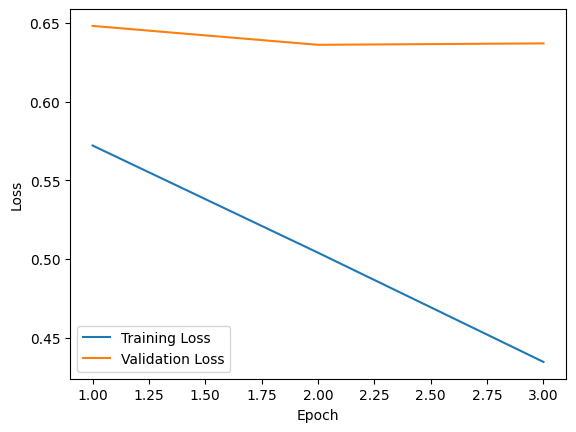

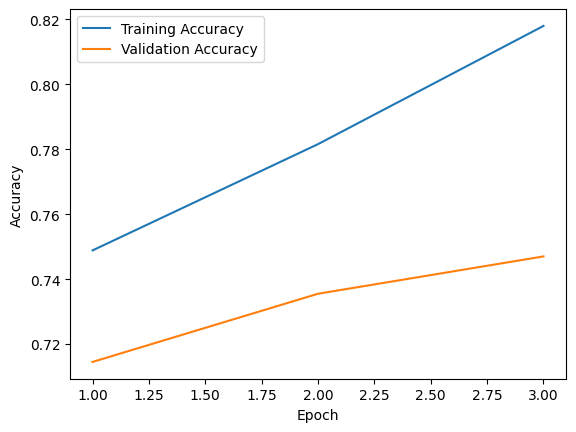

In [18]:
# Plot the graph
epochs = range(1, number_of_epochs+1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Final test on the trained model

In [19]:
test_encodings = tokenizer(test_text, padding=True, truncation=True, return_tensors='tf')
test_labels = tf.convert_to_tensor(tf.one_hot(test_labels, 3))

loss, accuracy = model.evaluate(test_encodings, test_labels)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

384/384 [==============================] - 30s 77ms/step - loss: 0.7052 - accuracy: 0.6917
Test Loss: 0.7052450776100159, Test Accuracy: 0.6917127966880798


## TODO

other transformers

effect on processings